In [207]:
import requests

import re

import numpy as np
import pandas as pd

from bs4 import BeautifulSoup

import pprint

from skimage import io, color, filters
from skimage.transform import resize, rotate

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy


import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from sklearn.metrics import pairwise_distances

from PIL import Image
import pickle
from datetime import datetime
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px



import scipy
import os
import matplotlib
from matplotlib import pyplot as plt

import itertools

import shutil
import random
import glob


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from PIL import Image
from IPython.display import display, Image


matplotlib.style.use('ggplot')
%matplotlib inline

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1*X GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=(1024*4))])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
# import requests

# import csv

# import pandas as pd

# from bs4 import BeautifulSoup


# def get_page(url):

#     response = requests.get(url)

#     if not response.ok:
#         print('Server responded: ', response.status_code)
#     else:
#         soup = BeautifulSoup(response.text, 'lxml')
#     return soup


# def get_detail_data(soup):

#     # title
#     # price
#     # image
#     # description

#     try:
#         # title = soup.find('h1', id='itemTitle').get('span')
#         title = soup.find('span', class_='g-hdn').next_sibling
#     except:
#         title = ''
    
#     try:
#         p = soup.find('span', id='prcIsum').text.strip()
#         currency, price = p.split(' ')
#     except:
#         price = ''
#         currency = ''
    
#     try:
#         img = soup.find('img', id='icImg').get('src')
#     except:
#         img = ''
    
#     try:
#         # desc = [tr.find_all('td') for tr in soup.find('div', id='viTabs_0_is').find('table').find_all('tr')]
        
#         table = soup.find('div', id='viTabs_0_is').find('table')
#         table_rows = table.find_all('tr')
        
#         d = []

#         for tr in table_rows:
#             td = tr.find_all('td')
#             row = [tr.get_text(strip=True) for tr in td]
#             d.append(row)

#         try:
#             cols = [x[0] for x in d] + [x[2] for x in d]
#         except:
#             cols = [x[0] for x in d]
#         try:
#             vals = [x[1] for x in d] + [x[3] for x in d]
#         except:
#             vals = [x[1] for x in d]
#         attrs = {k: v for k,v in zip(cols, vals)}

#         desc = attrs
#         # desc = pd.DataFrame.from_dict(attrs, orient='index').T
#     except:
#         desc = ''
    
    
#     data = {
#         'title': title,
#         'price': price,
#         'currency': currency,
#         'image': img,
#         'desc': desc
#     }

#     return data


# def get_index_data(soup):

#     try:
#         links = soup.find_all('a', class_='s-item__link')
#     except:
#         links = []
    
#     urls = [item.get('href') for item in links]

#     return urls


# def write_csv(data, url, cat):
    
#     file_name = str(cat) + '.csv'
    
#     with open(file_name, 'a') as csvfile:
#         writer = csv.writer(csvfile)

#         row = [data['title'], data['price'], data['currency'], data['desc'], data['image'], url]

#         writer.writerow(row)




In [4]:
# def main(url, cat):
    
#     page = 1

#     # print(get_detail_data(get_page(url)))
#     while requests.get(url).ok==True:

#         products = get_index_data(get_page(url))

#         for link in products:
#             data = get_detail_data(get_page(link))
#             write_csv(data, link, cat)

#         page += 1

#         url = url + '&_pgn=' + str(page)

In [5]:
remove_words = ['Condition:',
 'Pre-owned', 'An', 'an'
 'item',
 'that',
 'has',
 'been',
 'used',
 'or',
 'worn',
 'previously.',
 'See',
 'the',
 'seller',
 'listing',
 'for',
 'full',
 'details',
 'anddescription',
 'of',
 'any',
 'imperfections', 'See',
 'all',
 'condition',
 'definitions',
 'opens',
 'in',
 'a',
 'or',
 'tab...Read',
 'moreabout',
 'the',
 'condition','',

 'Condition',
 'Features', 'UPC'


 'Size',

 'definitions-',
 'imperfections.See',
 'item',
 'new',
 's']

In [6]:
boots = pd.read_csv('./data/boots.csv', names=['title', 'price', 'currency', 'attributes', 'image_link', 'listing_link'])

In [7]:
boots.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39216 entries, 0 to 39215
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         38341 non-null  object
 1   price         25289 non-null  object
 2   currency      25289 non-null  object
 3   attributes    26335 non-null  object
 4   image_link    38341 non-null  object
 5   listing_link  39216 non-null  object
dtypes: object(6)
memory usage: 1.8+ MB


In [8]:
urls = pd.DataFrame(boots.image_link)

In [9]:
boots = boots.drop(urls[urls.image_link.isnull()].index, axis=0)

In [10]:
boots.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38341 entries, 0 to 39215
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         38341 non-null  object
 1   price         25289 non-null  object
 2   currency      25289 non-null  object
 3   attributes    26335 non-null  object
 4   image_link    38341 non-null  object
 5   listing_link  38341 non-null  object
dtypes: object(6)
memory usage: 2.0+ MB


In [11]:
urls = pd.DataFrame(boots.image_link)

In [12]:
# rows = []

# for index, i in urls.iterrows():
#     rows.append(i[-1])

# counter = 0

# for i in rows:
#     file_name = './imgs/boots' + str(counter) + '.jpg'

#     response = requests.get(i)
#     file = open(file_name, "wb")
#     file.write(response.content)
#     file.close()
#     counter += 1

In [13]:
boots['i'] = boots.index

boots.head()

for i in boots.index:
    boots['i'][i] = './imgs/boots/boots' + str(i) + '.jpg'

boots.head()

boots['price'] = boots['price'].replace('[^.0-9]', '', regex=True).astype(float)

boots.describe()

,price
count,25289.000000
mean,101.230545
std,73.554472
min,17.850000
25%,55.950000
50%,77.990000
75%,120.000000
max,447.000000


In [14]:
boots.currency.unique()

array(['US', nan], dtype=object)

In [235]:
boots['price'] = boots['price'].fillna(np.round(boots.price.mean(),2))
boots['currency'] = boots['currency'].fillna('US')
boots['category'] = 'boots'



boots['attributes'] = boots['attributes'].fillna('boot')

aaa = list(boots.attributes)

aaa = [re.sub(r'[^a-zA-Z0-9.-]', ' ', s) for s in aaa]

aaa[0]

aaa = [list(set(x.split(' ')) - set(remove_words)) for x in aaa]

boots['tags'] = aaa


In [236]:
boots.head()

,title,price,currency,attributes,image_link,listing_link,i,tags,category
0,Oakley Combat Boots Vibram Sole Size 9.5 Tacti...,40.00,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/aJcAAOSwa6Jf478...,https://www.ebay.com/itm/Oakley-Combat-Boots-V...,./imgs/boots/boots0.jpg,"[Closure, Lace, Size, Upper, Material, Waterpr...",boots
1,Crockett & Jones England Brown Boots Shoes ME...,129.00,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/ad0AAOSwjGxf454...,https://www.ebay.com/itm/Crockett-Jones-Englan...,./imgs/boots/boots1.jpg,"[not, Jones, Does, apply, UPC, Shoe, window, D...",boots
2,Tecovas - The Duke Mens Cowboy Boots Size 10.5D,169.00,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/vxQAAOSwQqRf5AV...,https://www.ebay.com/itm/Tecovas-The-Duke-Mens...,./imgs/boots/boots2.jpg,"[Tecovas, Boot, Color, Material, Character, wi...",boots
3,ANDERSON BEAN S1116 MIKE TYSON BISON & BLUE LA...,50.00,US,boot,https://i.ebayimg.com/images/g/rDIAAOSwVhFf498...,https://www.ebay.com/itm/ANDERSON-BEAN-S1116-M...,./imgs/boots/boots3.jpg,[boot],boots
4,Red Wing 866 Pecos Pull On Work Boots 9 2nds,69.99,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/SBoAAOSwhHZf5Ce...,https://www.ebay.com/itm/Red-Wing-866-Pecos-Pu...,./imgs/boots/boots4.jpg,"[On, Boot, Shoes, Color, Material, Leather, Ch...",boots


In [17]:
casual_shirts = pd.read_csv('./data/casual_shirts.csv', names=['title', 'price', 'currency', 'attributes', 'image_link', 'listing_link'])

In [18]:
casual_shirts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27330 entries, 0 to 27329
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         27282 non-null  object
 1   price         19801 non-null  object
 2   currency      19801 non-null  object
 3   attributes    15376 non-null  object
 4   image_link    27282 non-null  object
 5   listing_link  27330 non-null  object
dtypes: object(6)
memory usage: 1.3+ MB


In [19]:
urls = pd.DataFrame(casual_shirts.image_link)

In [20]:
casual_shirts = casual_shirts.drop(urls[urls.image_link.isnull()].index, axis=0)

In [21]:
casual_shirts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27282 entries, 0 to 27329
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         27282 non-null  object
 1   price         19801 non-null  object
 2   currency      19801 non-null  object
 3   attributes    15376 non-null  object
 4   image_link    27282 non-null  object
 5   listing_link  27282 non-null  object
dtypes: object(6)
memory usage: 1.5+ MB


In [22]:
urls = pd.DataFrame(casual_shirts.image_link)

In [23]:
# rows = []

# for index, i in urls.iterrows():
#     rows.append(i[-1])

# counter = 0

# for i in rows:
#     file_name = './imgs/casualshirt' + str(counter) + '.jpg'

#     response = requests.get(i)
#     file = open(file_name, "wb")
#     file.write(response.content)
#     file.close()
#     counter += 1

In [24]:
casual_shirts['i'] = casual_shirts.index

casual_shirts.head()

for i in casual_shirts.index:
    casual_shirts['i'][i] = './imgs/casualshirt/casualshirt' + str(i) + '.jpg'

casual_shirts.head()

casual_shirts.iloc[19504]

casual_shirts['price'] = casual_shirts['price'].replace('[^.0-9]', '', regex=True).astype(float)

casual_shirts.describe()

,price
count,19801.000000
mean,40.399908
std,43.631460
min,6.000000
25%,24.890000
50%,29.990000
75%,39.990000
max,700.000000


In [25]:
casual_shirts['price'] = casual_shirts['price'].fillna(np.round(casual_shirts.price.mean(),2))
casual_shirts['currency'] = casual_shirts['currency'].fillna('US')
casula_shirts['category'] = 'casual shirt'



casual_shirts['attributes'] = casual_shirts['attributes'].fillna('casual shirt')

aaa = list(casual_shirts.attributes)

aaa = [re.sub(r'[^a-zA-Z0-9.-]', ' ', s) for s in aaa]

aaa[0]

aaa = [list(set(x.split(' ')) - set(remove_words)) for x in aaa]

casual_shirts['tags'] = aaa

casual_shirts.head()


,title,price,currency,attributes,image_link,listing_link,i,tags
0,VTG The Alaskan Mens 2XL Tall Grn / White Pla...,30.00,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/bUkAAOSw2Plf4zh...,https://www.ebay.com/itm/VTG-The-Alaskan-Mens-...,./imgs/casualshirt/casualshirt0.jpg,"[1970s, Length, Neckline, Collared, Big, The, ..."
1,Vineyard Vines Performance Striped Blue Mens P...,16.00,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/EskAAOSwLttf4tN...,https://www.ebay.com/itm/Vineyard-Vines-Perfor...,./imgs/casualshirt/casualshirt1.jpg,"[Length, Neckline, Collared, Color, Material, ..."
2,Nike Golf Dri Fit Polo Shirt Short Sleeve Red ...,24.96,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/RTwAAOSwETVf4tT...,https://www.ebay.com/itm/Nike-Golf-Dri-Fit-Pol...,./imgs/casualshirt/casualshirt2.jpg,"[not, Length, Neckline, Nike, Collared, White,..."
3,Champs Men's Casual Shirt,12.99,US,casual shirt,https://i.ebayimg.com/images/g/IksAAOSwTcdf40w...,https://www.ebay.com/itm/Champs-Mens-Casual-Sh...,./imgs/casualshirt/casualshirt3.jpg,"[casual, shirt]"
4,Brooks Brothers Men's Casual Shirt,12.99,US,casual shirt,https://i.ebayimg.com/images/g/NL0AAOSwW-9f40s...,https://www.ebay.com/itm/Brooks-Brothers-Mens-...,./imgs/casualshirt/casualshirt4.jpg,"[casual, shirt]"


In [26]:
casual_shoes = pd.read_csv('./data/casual_shoes.csv', names=['title', 'price', 'currency', 'attributes', 'image_link', 'listing_link'])

In [27]:
casual_shoes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39312 entries, 0 to 39311
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         38508 non-null  object
 1   price         28767 non-null  object
 2   currency      28767 non-null  object
 3   attributes    27046 non-null  object
 4   image_link    38508 non-null  object
 5   listing_link  39312 non-null  object
dtypes: object(6)
memory usage: 1.8+ MB


In [28]:
urls = pd.DataFrame(casual_shoes.image_link)

In [29]:
casual_shoes = casual_shoes.drop(urls[urls.image_link.isnull()].index, axis=0)

In [30]:
casual_shoes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38508 entries, 0 to 39311
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         38508 non-null  object
 1   price         28767 non-null  object
 2   currency      28767 non-null  object
 3   attributes    27046 non-null  object
 4   image_link    38508 non-null  object
 5   listing_link  38508 non-null  object
dtypes: object(6)
memory usage: 2.1+ MB


In [31]:
urls = pd.DataFrame(casual_shoes.image_link)

In [32]:
# rows = []

# for index, i in urls.iterrows():
#     rows.append(i[-1])

# counter = 0

# for i in rows:
#     file_name = './imgs/casualshoe' + str(counter) + '.jpg'

#     response = requests.get(i)
#     file = open(file_name, "wb")
#     file.write(response.content)
#     file.close()
#     counter += 1

In [33]:
casual_shoes['i'] = casual_shoes.index

casual_shoes.head()

for i in casual_shoes.index:
    casual_shoes['i'][i] = './imgs/casualshoe/casualshoe' + str(i) + '.jpg'

casual_shoes.head()

casual_shoes.iloc[29294]

casual_shoes['price'] = casual_shoes['price'].replace('[^.0-9]', '', regex=True).astype(float)

casual_shoes.describe()

,price
count,28767.000000
mean,114.504896
std,174.275984
min,9.900000
25%,30.000000
50%,46.000000
75%,98.000000
max,900.000000


In [34]:
casual_shoes['price'] = casual_shoes['price'].fillna(np.round(casual_shoes.price.mean(),2))
casual_shoes['currency'] = casual_shoes['currency'].fillna('US')
casual_shoes['category'] = 'casual shoe'



casual_shoes['attributes'] = casual_shoes['attributes'].fillna('casual shoe')

aaa = list(casual_shoes.attributes)

aaa = [re.sub(r'[^a-zA-Z0-9.-]', ' ', s) for s in aaa]

aaa[0]

aaa = [list(set(x.split(' ')) - set(remove_words)) for x in aaa]

casual_shoes['tags'] = aaa

casual_shoes.head()


,title,price,currency,attributes,image_link,listing_link,i,tags
0,Steve Madden Men’s Casual Shoes Sz 11,30.00,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/UB0AAOSwsFdf4~u...,https://www.ebay.com/itm/Steve-Madden-Men-s-Ca...,./imgs/casualshoe/casualshoe0.jpg,"[Size, 11, Shoe, Gray, window, Men, Style, US,..."
1,Timberland Mens Waterproof Shoes Size 11 Genui...,39.99,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/BRYAAOSwyHhf5As...,https://www.ebay.com/itm/Timberland-Mens-Water...,./imgs/casualshoe/casualshoe1.jpg,"[Outsole, Loafer, Material, Waterproof, Leathe..."
2,"Shoes for Crews Bloodstone Black, Style# 62101...",29.99,US,casual shoe,https://i.ebayimg.com/images/g/avMAAOSwsKxfqge...,https://www.ebay.com/itm/Shoes-for-Crews-Blood...,./imgs/casualshoe/casualshoe2.jpg,"[casual, shoe]"
3,Mens Authentic Louis Vuitton Run Away Monogram...,650.00,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/kHgAAOSwxzxfu~G...,https://www.ebay.com/itm/Mens-Authentic-Louis-...,./imgs/casualshoe/casualshoe3.jpg,"[window, MPN, Run, Style, Model, RUN, Sneaker,..."
4,Olukai Mens Light Brown Fabric Walking Casual ...,39.50,US,casual shoe,https://i.ebayimg.com/images/g/30QAAOSwXkRf4~j...,https://www.ebay.com/itm/Olukai-Mens-Light-Bro...,./imgs/casualshoe/casualshoe4.jpg,"[casual, shoe]"


In [35]:
coats_jackets = pd.read_csv('./data/coats_jackets.csv', names=['title', 'price', 'currency', 'attributes', 'image_link', 'listing_link'])

In [36]:
coats_jackets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39216 entries, 0 to 39215
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         39208 non-null  object
 1   price         29871 non-null  object
 2   currency      29871 non-null  object
 3   attributes    31541 non-null  object
 4   image_link    39208 non-null  object
 5   listing_link  39216 non-null  object
dtypes: object(6)
memory usage: 1.8+ MB


In [37]:
urls = pd.DataFrame(coats_jackets.image_link)

In [38]:
coats_jackets = coats_jackets.drop(urls[urls.image_link.isnull()].index, axis=0)

In [39]:
coats_jackets = coats_jackets.drop([18499], axis=0)

In [40]:
coats_jackets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39207 entries, 0 to 39215
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         39207 non-null  object
 1   price         29870 non-null  object
 2   currency      29870 non-null  object
 3   attributes    31540 non-null  object
 4   image_link    39207 non-null  object
 5   listing_link  39207 non-null  object
dtypes: object(6)
memory usage: 2.1+ MB


In [41]:
coats_jackets.iloc[18495]

title            Dunning Golf Men’s Gray Full Zip Jacket Sz Large
price                                                      $48.88
currency                                                       US
attributes                                                    NaN
image_link      https://i.ebayimg.com/images/g/bxIAAOSwgAZfWq9...
listing_link    https://www.ebay.com/itm/Dunning-Golf-Men-s-Gr...
Name: 18500, dtype: object

In [42]:
urls = pd.DataFrame(coats_jackets.image_link)

In [43]:
# rows = []

# for index, i in urls.iterrows():
#     rows.append(i[-1])

# counter = 0

# for i in rows:
#     file_name = './imgs/coatjacket/coatjacket' + str(counter) + '.jpg'

#     response = requests.get(i)
#     file = open(file_name, "wb")
#     file.write(response.content)
#     file.close()
#     counter += 1

In [44]:
coats_jackets['i'] = coats_jackets.index

coats_jackets.head()

for i in coats_jackets.index:
    coats_jackets['i'][i] = './imgs/coatjacket/coatjacket' + str(i) + '.jpg'

coats_jackets.head()

coats_jackets.iloc[18495]

coats_jackets['price'] = coats_jackets['price'].replace('[^.0-9]', '', regex=True).astype(float)

coats_jackets.describe()

,price
count,29870.000000
mean,114.110057
std,113.853922
min,7.000000
25%,49.990000
50%,70.000000
75%,150.000000
max,1000.000000


In [45]:
coats_jackets['price'] = coats_jackets['price'].fillna(np.round(coats_jackets.price.mean(),2))
coats_jackets['currency'] = coats_jackets['currency'].fillna('US')
coats_jackets['category'] = 'coat'


coats_jackets['attributes'] = coats_jackets['attributes'].fillna('coat jacket')

aaa = list(coats_jackets.attributes)

aaa = [re.sub(r'[^a-zA-Z0-9.-]', ' ', s) for s in aaa]

aaa[0]

aaa = [list(set(x.split(' ')) - set(remove_words)) for x in aaa]

coats_jackets['tags'] = aaa

coats_jackets.head()

,title,price,currency,attributes,image_link,listing_link,i,tags
0,Moose Knuckles Shearling Collar Jacket Coat Si...,250.00,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/EYgAAOSwT~lf48B...,https://www.ebay.com/itm/Moose-Knuckles-Shearl...,./imgs/coatjacket/coatjacket0.jpg,"[Size, Regular, Black, window, Moose, Knuckles..."
1,Marmot Men XL Full Zip Ski Shell Jacket Blue W...,39.99,US,coat jacket,https://i.ebayimg.com/images/g/I5gAAOSwFdNf4ni...,https://www.ebay.com/itm/Marmot-Men-XL-Full-Zi...,./imgs/coatjacket/coatjacket1.jpg,"[coat, jacket]"
2,Patagonia Piton Fleece Jacket Men's XL Orange,60.00,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/lPcAAOSwc-df49J...,https://www.ebay.com/itm/Patagonia-Piton-Fleec...,./imgs/coatjacket/coatjacket2.jpg,"[Size, Orange, Fabric, window, Style, Jacket, ..."
3,Carhartt Sherpa Lined Red Flannel Shirt Jacket M,50.00,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/~ggAAOSwq1Ff474...,https://www.ebay.com/itm/Carhartt-Sherpa-Lined...,./imgs/coatjacket/coatjacket3.jpg,"[Size, Regular, Flannel, window, Red, Style, C..."
4,Patagonia Polartec Fleece Base Pullover Men's ...,39.99,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/qMcAAOSwDXlf47U...,https://www.ebay.com/itm/Patagonia-Polartec-Fl...,./imgs/coatjacket/coatjacket4.jpg,"[Care, not, apply, Classic, Accents, Spring, W..."


In [46]:
dress_shirts = pd.read_csv('./data/dress_shirts.csv', names=['title', 'price', 'currency', 'attributes', 'image_link', 'listing_link'])

In [47]:
dress_shirts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39216 entries, 0 to 39215
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         39216 non-null  object
 1   price         21790 non-null  object
 2   currency      21790 non-null  object
 3   attributes    27957 non-null  object
 4   image_link    39216 non-null  object
 5   listing_link  39216 non-null  object
dtypes: object(6)
memory usage: 1.8+ MB


In [48]:
urls = pd.DataFrame(dress_shirts.image_link)

In [49]:
dress_shirts = dress_shirts.drop(urls[urls.image_link.isnull()].index, axis=0)

In [50]:
dress_shirts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39216 entries, 0 to 39215
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         39216 non-null  object
 1   price         21790 non-null  object
 2   currency      21790 non-null  object
 3   attributes    27957 non-null  object
 4   image_link    39216 non-null  object
 5   listing_link  39216 non-null  object
dtypes: object(6)
memory usage: 2.1+ MB


In [51]:
urls = pd.DataFrame(dress_shirts.image_link)

In [52]:
# rows = []

# for index, i in urls.iterrows():
#     rows.append(i[-1])

# counter = 0

# for i in rows:
#     file_name = './imgs/dressshirt/dressshirt' + str(counter) + '.jpg'

#     response = requests.get(i)
#     file = open(file_name, "wb")
#     file.write(response.content)
#     file.close()
#     counter += 1

In [53]:
dress_shirts['i'] = dress_shirts.index

dress_shirts.head()

for i in dress_shirts.index:
    dress_shirts['i'][i] = './imgs/dressshirt/dressshirt' + str(i) + '.jpg'

dress_shirts.head()

dress_shirts.iloc[37434]

dress_shirts['price'] = dress_shirts['price'].replace('[^.0-9]', '', regex=True).astype(float)

dress_shirts.describe()

,price
count,21790.000000
mean,36.577712
std,15.876785
min,5.990000
25%,25.000000
50%,33.000000
75%,44.980000
max,148.000000


In [54]:
dress_shirts['price'] = dress_shirts['price'].fillna(np.round(dress_shirts.price.mean(),2))
dress_shirts['currency'] = dress_shirts['currency'].fillna('US')
dress_shirt['category'] = 'dress shirt'



dress_shirts['attributes'] = dress_shirts['attributes'].fillna('dress shirt')

aaa = list(dress_shirts.attributes)

aaa = [re.sub(r'[^a-zA-Z0-9.-]', ' ', s) for s in aaa]

aaa[0]

aaa = [list(set(x.split(' ')) - set(remove_words)) for x in aaa]

dress_shirts['tags'] = aaa

dress_shirts.head()

,title,price,currency,attributes,image_link,listing_link,i,tags
0,Mens Dress Shirt,36.58,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/2kkAAOSwgEJfvf7...,https://www.ebay.com/itm/Mens-Dress-Shirt/2338...,./imgs/dressshirt/dressshirt0.jpg,"[Size, S, Regular, window, Multicolor, Color, ..."
1,Calvin Klein Dress Shirt,36.58,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/3hsAAOSwhrRfvf-...,https://www.ebay.com/itm/Calvin-Klein-Dress-Sh...,./imgs/dressshirt/dressshirt1.jpg,"[Size, Regular, window, Multicolor, Color, Typ..."
2,Polo Ralph Lauren dress shirt XXL oxford butto...,27.99,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/rEYAAOSwBGJf4t8...,https://www.ebay.com/itm/Polo-Ralph-Lauren-dre...,./imgs/dressshirt/dressshirt2.jpg,"[Classic, All, Length, 2XL, Neckline, Collared..."
3,UNTUCKit mens Purple Long sleeve dress shirt S...,29.99,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/GnIAAOSwPzVfk5C...,https://www.ebay.com/itm/UNTUCKit-mens-Purple-...,./imgs/dressshirt/dressshirt3.jpg,"[Care, not, Spring, Length, V-Neck, Neckline, ..."
4,Jos A Bank Traveler White Shirt Size 15 34,25.00,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/1NsAAOSwDxdf4t3...,https://www.ebay.com/itm/Jos-A-Bank-Traveler-W...,./imgs/dressshirt/dressshirt4.jpg,"[not, Length, Cotton, Down, Does, Regular, app..."


In [55]:
dress_shoes = pd.read_csv('./data/dress_shoes.csv', names=['title', 'price', 'currency', 'attributes', 'image_link', 'listing_link'])

In [56]:
dress_shoes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39264 entries, 0 to 39263
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         38638 non-null  object
 1   price         25771 non-null  object
 2   currency      25771 non-null  object
 3   attributes    23602 non-null  object
 4   image_link    38638 non-null  object
 5   listing_link  39264 non-null  object
dtypes: object(6)
memory usage: 1.8+ MB


In [57]:
urls = pd.DataFrame(dress_shoes.image_link)

In [58]:
dress_shoes = dress_shoes.drop(urls[urls.image_link.isnull()].index, axis=0)

In [59]:
dress_shoes= dress_shoes.drop(dress_shoes[dress_shoes.image_link.str.contains("shoeffl")].index, axis=0)

In [60]:
dress_shoes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38599 entries, 0 to 39263
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         38599 non-null  object
 1   price         25732 non-null  object
 2   currency      25732 non-null  object
 3   attributes    23602 non-null  object
 4   image_link    38599 non-null  object
 5   listing_link  38599 non-null  object
dtypes: object(6)
memory usage: 2.1+ MB


In [61]:
urls = pd.DataFrame(dress_shoes.image_link)

In [62]:
# rows = []

# for index, i in urls.iterrows():
#     rows.append(i[-1])

# counter = 0

# for i in rows:
#     file_name = './imgs/dressshoe/dressshoe' + str(counter) + '.jpg'

#     response = requests.get(i)
#     file = open(file_name, "wb")
#     file.write(response.content)
#     file.close()
#     counter += 1

In [63]:
dress_shoes['i'] = dress_shoes.index

dress_shoes.head()

for i in dress_shoes.index:
    dress_shoes['i'][i] = './imgs/dressshoe/dressshoe' + str(i) + '.jpg'

dress_shoes.head()

dress_shoes.iloc[35495]

dress_shoes['price'] = dress_shoes['price'].replace('[^.0-9]', '', regex=True).astype(float)

dress_shoes.describe()

,price
count,25732.000000
mean,82.300017
std,81.964743
min,8.990000
25%,36.980000
50%,49.990000
75%,89.990000
max,499.000000


In [64]:
dress_shoes['price'] = dress_shoes['price'].fillna(np.round(dress_shoes.price.mean(),2))
dress_shoes['currency'] = dress_shoes['currency'].fillna('US')
dress_shoes['category'] = 'dress shoe'



dress_shoes['attributes'] = dress_shoes['attributes'].fillna('dress shoe')

aaa = list(dress_shoes.attributes)

aaa = [re.sub(r'[^a-zA-Z0-9.-]', ' ', s) for s in aaa]

aaa[0]

aaa = [list(set(x.split(' ')) - set(remove_words)) for x in aaa]

dress_shoes['tags'] = aaa

dress_shoes.head()

,title,price,currency,attributes,image_link,listing_link,i,tags
0,Rockport oxford mens shoes 9.5,39.00,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/iA8AAOSwkYpf5I-...,https://www.ebay.com/itm/Rockport-oxford-mens-...,./imgs/dressshoe/dressshoe0.jpg,"[Rockport, Size, Upper, Material, Shoe, Leathe..."
1,Dr Doc Martens Black White Oxford Wingtip Brog...,49.99,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/ReUAAOSwxB5ftKj...,https://www.ebay.com/itm/Dr-Doc-Martens-Black-...,./imgs/dressshoe/dressshoe1.jpg,"[longwing, 10458, Euro, Spring, Black, Manufac..."
2,Johnson Murphy Men Dress Shoes Sz 10.5-D,50.00,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/qF8AAOSwmCxf5KM...,https://www.ebay.com/itm/Johnson-Murphy-Men-Dr...,./imgs/dressshoe/dressshoe2.jpg,"[Johnston, not, Black, Insole, Manufacture, Up..."
3,VTG Florsheim Imperial Wing Tip Black Oxford D...,24.99,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/eQAAAOSwevBf5K2...,https://www.ebay.com/itm/VTG-Florsheim-Imperia...,./imgs/dressshoe/dressshoe3.jpg,"[Insole, Manufacture, Lining, Round, Material,..."
4,Allen Edmonds Mens Shoe Bridgeton Model Tassel...,36.97,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/8KUAAOSwdHlf5Ku...,https://www.ebay.com/itm/Allen-Edmonds-Mens-Sh...,./imgs/dressshoe/dressshoe4.jpg,"[Accents, Black, Kilt, Tasseled, Dress, Color,..."


In [65]:
jeans = pd.read_csv('./data/jeans.csv', names=['title', 'price', 'currency', 'attributes', 'image_link', 'listing_link'])

jeans.info()

urls = pd.DataFrame(jeans.image_link)

jeans = jeans.drop(urls[urls.image_link.isnull()].index, axis=0)

jeans.info()

urls = pd.DataFrame(jeans.image_link)

# rows = []

# for index, i in urls.iterrows():
#     rows.append(i[-1])

# counter = 0

# for i in rows:
#     file_name = './imgs/jeans/jeans' + str(counter) + '.jpg'

#     response = requests.get(i)
#     file = open(file_name, "wb")
#     file.write(response.content)
#     file.close()
#     counter += 1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29083 entries, 0 to 29082
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         28808 non-null  object
 1   price         20828 non-null  object
 2   currency      20828 non-null  object
 3   attributes    19251 non-null  object
 4   image_link    28808 non-null  object
 5   listing_link  29083 non-null  object
dtypes: object(6)
memory usage: 1.3+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 28808 entries, 0 to 29082
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         28808 non-null  object
 1   price         20828 non-null  object
 2   currency      20828 non-null  object
 3   attributes    19251 non-null  object
 4   image_link    28808 non-null  object
 5   listing_link  28808 non-null  object
dtypes: object(6)
memory usage: 1.5+ MB


In [66]:
jeans['i'] = jeans.index

jeans.head()

for i in jeans.index:
    jeans['i'][i] = './imgs/jeans/jeans' + str(i) + '.jpg'

jeans.head()

jeans.iloc[24391]

jeans['price'] = jeans['price'].replace('[^.0-9]', '', regex=True).astype(float)

jeans.describe()

,price
count,20828.000000
mean,41.806169
std,46.988513
min,5.000000
25%,23.990000
50%,32.000000
75%,49.990000
max,950.000000


In [67]:
jeans['price'] = jeans['price'].fillna(np.round(jeans.price.mean(),2))
jeans['currency'] = jeans['currency'].fillna('US')
jeans['category'] = 'jeans'



jeans['attributes'] = jeans['attributes'].fillna('jeans')

aaa = list(jeans.attributes)

aaa = [re.sub(r'[^a-zA-Z0-9.-]', ' ', s) for s in aaa]

aaa[0]

aaa = [list(set(x.split(' ')) - set(remove_words)) for x in aaa]

jeans['tags'] = aaa

jeans.head()

,title,price,currency,attributes,image_link,listing_link,i,tags
0,rogue territory Chino,89.00,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/RZoAAOSwGgdf4kd...,https://www.ebay.com/itm/rogue-territory-Chino...,./imgs/jeans/jeans0.jpg,"[Jeans, Beige, Size, Regular, Rogue, Inseam, D..."
1,"""GRADE A"" CARHARTT AUTHENTIC COTTON DENIM WO...",8.00,US,jeans,https://i.ebayimg.com/images/g/kHIAAOSwleBf0tv...,https://www.ebay.com/itm/GRADE-A-CARHARTT-AUTH...,./imgs/jeans/jeans1.jpg,[jeans]
2,Pelle Pelle Mens Jeans Black 36 X 34,29.97,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/xBoAAOSwhTRf4nU...,https://www.ebay.com/itm/Pelle-Pelle-Mens-Jean...,./imgs/jeans/jeans2.jpg,"[36, Jeans, Pelle, Size, Regular, Inseam, Depa..."
3,Carhartt Dungaree Fit Brown Jeans 34 x 30 In...,15.00,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/Ce8AAOSww6lf4nE...,https://www.ebay.com/itm/Carhartt-Dungaree-Fit...,./imgs/jeans/jeans3.jpg,"[Jeans, Size, Straight, 32, Regular, Inseam, D..."
4,Hollister Classic Straight Mens Medium Wash Je...,15.00,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/CCkAAOSwpsJfuX8...,https://www.ebay.com/itm/Hollister-Classic-Str...,./imgs/jeans/jeans4.jpg,"[Classic, Color, 32, Regular, Inseam, window, ..."


In [68]:
pants = pd.read_csv('./data/pants.csv', names=['title', 'price', 'currency', 'attributes', 'image_link', 'listing_link'])

urls = pd.DataFrame(pants.image_link)

pants = pants.drop(urls[urls.image_link.isnull()].index, axis=0)

urls = pd.DataFrame(pants.image_link)

# rows = []

# for index, i in urls.iterrows():
#     rows.append(i[-1])

# counter = 0

# for i in rows:
#     file_name = './imgs/pants' + str(counter) + '.jpg'

#     response = requests.get(i)
#     file = open(file_name, "wb")
#     file.write(response.content)
#     file.close()
#     counter += 1

pants['i'] = pants.index

pants.head()

for i in pants.index:
    pants['i'][i] = './imgs/pants/pants' + str(i) + '.jpg'

pants.head()

pants.iloc[20791]

pants['price'] = pants['price'].replace('[^.0-9]', '', regex=True).astype(float)

pants.describe()

,price
count,18286.000000
mean,42.470873
std,36.637599
min,4.490000
25%,24.990000
50%,29.990000
75%,48.000000
max,295.000000


In [69]:
pants['price'] = pants['price'].fillna(np.round(pants.price.mean(),2))
pants['currency'] = pants['currency'].fillna('US')
pants['category'] = 'pants'



pants['attributes'] = pants['attributes'].fillna('pants')

aaa = list(pants.attributes)

aaa = [re.sub(r'[^a-zA-Z0-9.-]', ' ', s) for s in aaa]

aaa[0]

aaa = [list(set(x.split(' ')) - set(remove_words)) for x in aaa]

pants['tags'] = aaa

pants.head()

,title,price,currency,attributes,image_link,listing_link,i,tags
0,Dickies Carpenter Jeans Dungaree Five Pocket H...,19.99,US,pants,https://i.ebayimg.com/images/g/DAoAAOSwaldesiK...,https://www.ebay.com/itm/Dickies-Carpenter-Jea...,./imgs/pants/pants0.jpg,[pants]
1,Carhartt work pants 32x30,25.00,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/ME0AAOSwh1tf2Uw...,https://www.ebay.com/itm/Carhartt-work-pants-3...,./imgs/pants/pants1.jpg,"[Size, 32, Regular, Inseam, Department, Black,..."
2,Cargo Work Pants Uniform Used Cintas Unifirst ...,8.89,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/Q7gAAOSwWUVc3DR...,https://www.ebay.com/itm/Cargo-Work-Pants-Unif...,./imgs/pants/pants2.jpg,"[Item, Various, 27-36, Front, No, Regular, Ins..."
3,IBEX New Wool Order Men’s Pant Size 32,75.00,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/g1QAAOSw97dfyy9...,https://www.ebay.com/itm/IBEX-New-Wool-Order-M...,./imgs/pants/pants3.jpg,"[not, Black, Color, Does, apply, 32, Material,..."
4,CARHARTT DOUBLE KNEE PANTS 36X28 CARPENTER WOR...,27.99,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/e~cAAOSwHflf2Sm...,https://www.ebay.com/itm/CARHARTT-DOUBLE-KNEE-...,./imgs/pants/pants4.jpg,"[Care, 28, Mid, Pocket, Garment, Rise, 36, Fro..."


In [70]:
polos = pd.read_csv('./data/polo_shirt.csv', names=['title', 'price', 'currency', 'attributes', 'image_link', 'listing_link'])

In [71]:
polos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34299 entries, 0 to 34298
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         34299 non-null  object
 1   price         21302 non-null  object
 2   currency      21302 non-null  object
 3   attributes    22274 non-null  object
 4   image_link    34299 non-null  object
 5   listing_link  34299 non-null  object
dtypes: object(6)
memory usage: 1.6+ MB


In [72]:
urls = pd.DataFrame(polos.image_link)

In [73]:
polos = polos.drop(urls[urls.image_link.isnull()].index, axis=0)

In [74]:
polos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34299 entries, 0 to 34298
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         34299 non-null  object
 1   price         21302 non-null  object
 2   currency      21302 non-null  object
 3   attributes    22274 non-null  object
 4   image_link    34299 non-null  object
 5   listing_link  34299 non-null  object
dtypes: object(6)
memory usage: 1.8+ MB


In [75]:
urls = pd.DataFrame(polos.image_link)

In [76]:
# rows = []

# for index, i in urls.iterrows():
#     rows.append(i[-1])

# counter = 0

# for i in rows:
#     file_name = './imgs/polos/polo' + str(counter) + '.jpg'

#     response = requests.get(i)
#     file = open(file_name, "wb")
#     file.write(response.content)
#     file.close()
#     counter += 1

In [77]:
polos['i'] = polos.index

polos.head()

for i in polos.index:
    polos['i'][i] = './imgs/polos/polo' + str(i) + '.jpg'

polos.head()

polos.iloc[30556]

polos['price'] = polos['price'].replace('[^.0-9]', '', regex=True).astype(float)

polos.describe()

,price
count,21302.000000
mean,28.840177
std,14.885076
min,5.500000
25%,19.990000
50%,24.880000
75%,34.800000
max,170.000000


In [78]:
polos['price'] = polos['price'].fillna(np.round(polos.price.mean(),2))
polos['currency'] = polos['currency'].fillna('US')
polos['category'] = 'polo'



polos['attributes'] = polos['attributes'].fillna('polo')

aaa = list(polos.attributes)

aaa = [re.sub(r'[^a-zA-Z0-9.-]', ' ', s) for s in aaa]

aaa[0]

aaa = [list(set(x.split(' ')) - set(remove_words)) for x in aaa]

polos['tags'] = aaa

polos.head()

,title,price,currency,attributes,image_link,listing_link,i,tags
0,Van Heusen Studio Polo Slim Fit Men's Sz XL,5.50,US,polo,https://i.ebayimg.com/images/g/iFcAAOSw9BBf44g...,https://www.ebay.com/itm/Van-Heusen-Studio-Pol...,./imgs/polos/polo0.jpg,[polo]
1,Ducks Unlimited Green Short Sleeve Polo Shirt ...,21.99,US,polo,https://i.ebayimg.com/images/g/xDAAAOSwFjRf3l0...,https://www.ebay.com/itm/Ducks-Unlimited-Green...,./imgs/polos/polo1.jpg,[polo]
2,Rhoback Mens XL Performance Golf Collared Polo...,54.95,US,polo,https://i.ebayimg.com/images/g/ho0AAOSwQHVf44Y...,https://www.ebay.com/itm/Rhoback-Mens-XL-Perfo...,./imgs/polos/polo2.jpg,[polo]
3,RLX Golf Polo Medium,19.99,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/SbgAAOSwenZfqZR...,https://www.ebay.com/itm/RLX-Golf-Polo-Medium/...,./imgs/polos/polo3.jpg,"[Size, Polo, window, Slim, Multicolor, Fit, Co..."
4,Fred Perry Mens Large Embroidered Logo Collare...,33.95,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/upIAAOSwl5Bf44g...,https://www.ebay.com/itm/Fred-Perry-Mens-Large...,./imgs/polos/polo4.jpg,"[not, Size, Does, apply, Perry, Regular, UPC, ..."


In [79]:
shorts = pd.read_csv('./data/shorts.csv', names=['title', 'price', 'currency', 'attributes', 'image_link', 'listing_link'])

In [80]:
shorts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27070 entries, 0 to 27069
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         26901 non-null  object
 1   price         15266 non-null  object
 2   currency      15266 non-null  object
 3   attributes    21243 non-null  object
 4   image_link    26901 non-null  object
 5   listing_link  27070 non-null  object
dtypes: object(6)
memory usage: 1.2+ MB


In [81]:
urls = pd.DataFrame(shorts.image_link)

In [82]:
shorts = shorts.drop(urls[urls.image_link.isnull()].index, axis=0)

In [83]:
shorts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26901 entries, 0 to 27069
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         26901 non-null  object
 1   price         15266 non-null  object
 2   currency      15266 non-null  object
 3   attributes    21243 non-null  object
 4   image_link    26901 non-null  object
 5   listing_link  26901 non-null  object
dtypes: object(6)
memory usage: 1.4+ MB


In [84]:
urls = pd.DataFrame(shorts.image_link)

In [85]:
# rows = []

# for index, i in urls.iterrows():
#     rows.append(i[-1])

# counter = 0

# for i in rows:
#     file_name = './imgs/shorts/shorts' + str(counter) + '.jpg'

#     response = requests.get(i)
#     file = open(file_name, "wb")
#     file.write(response.content)
#     file.close()
#     counter += 1

In [86]:
shorts['i'] = shorts.index

shorts.head()

for i in shorts.index:
    shorts['i'][i] = './imgs/shorts/shorts' + str(i) + '.jpg'

shorts.head()

shorts.iloc[24820]

shorts['price'] = shorts['price'].replace('[^.0-9]', '', regex=True).astype(float)

shorts.describe()

,price
count,15266.000000
mean,40.019642
std,38.812002
min,5.990000
25%,23.000000
50%,29.300000
75%,44.990000
max,250.000000


In [87]:
shorts['price'] = shorts['price'].fillna(np.round(shorts.price.mean(),2))
shorts['currency'] = shorts['currency'].fillna('US')
shorts['category'] = 'shorts'


shorts['attributes'] = shorts['attributes'].fillna('shorts')

aaa = list(shorts.attributes)

aaa = [re.sub(r'[^a-zA-Z0-9.-]', ' ', s) for s in aaa]

aaa[0]

aaa = [list(set(x.split(' ')) - set(remove_words)) for x in aaa]

shorts['tags'] = aaa

shorts.head()

,title,price,currency,attributes,image_link,listing_link,i,tags
0,Nike Victory dri-fit shorts 482943 Men's Large L,23.00,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/dq0AAOSwjVhf43n...,https://www.ebay.com/itm/Nike-Victory-dri-fit-...,./imgs/shorts/shorts0.jpg,"[Size, Regular, Department, Black, window, L, ..."
1,Calvin Klein Mens Khaki Shorts-Blue Waist 32 G...,9.99,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/eIwAAOSwbV9f44k...,https://www.ebay.com/itm/Calvin-Klein-Mens-Kha...,./imgs/shorts/shorts1.jpg,"[Classic, Klein, Color, Cotton, 32, Material, ..."
2,Peter Millar Wicking Shorts Purple Size 34,29.97,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/JSYAAOSwp19f45D...,https://www.ebay.com/itm/Peter-Millar-Wicking-...,./imgs/shorts/shorts2.jpg,"[Classic, Size, Waist, Pattern, Solid, window,..."
3,Callaway Mens Black Golf Spandex Shorts Size 3...,9.99,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/U14AAOSwbLxf44f...,https://www.ebay.com/itm/Callaway-Mens-Black-G...,./imgs/shorts/shorts3.jpg,"[Size, Regular, Occasion, Waist, Pattern, wind..."
4,Wrangler Carpenter Cargo Khaki Shorts Men Size 36,12.99,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/qpYAAOSwD7Nfw84...,https://www.ebay.com/itm/Wrangler-Carpenter-Ca...,./imgs/shorts/shorts4.jpg,"[Classic, Beige, Size, Regular, Fabric, window..."


In [88]:
sneakers = pd.read_csv('./data/sneakers.csv', names=['title', 'price', 'currency', 'attributes', 'image_link', 'listing_link'])

In [89]:
sneakers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39264 entries, 0 to 39263
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         32132 non-null  object
 1   price         27237 non-null  object
 2   currency      27237 non-null  object
 3   attributes    27039 non-null  object
 4   image_link    32132 non-null  object
 5   listing_link  39264 non-null  object
dtypes: object(6)
memory usage: 1.8+ MB


In [90]:
urls = pd.DataFrame(sneakers.image_link)

In [91]:
sneakers = sneakers.drop(urls[urls.image_link.isnull()].index, axis=0)

In [92]:
sneakers[sneakers.image_link.str.contains("shoeffl")]

,title,price,currency,attributes,image_link,listing_link


In [93]:
sneakers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32132 entries, 0 to 39263
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         32132 non-null  object
 1   price         27237 non-null  object
 2   currency      27237 non-null  object
 3   attributes    27039 non-null  object
 4   image_link    32132 non-null  object
 5   listing_link  32132 non-null  object
dtypes: object(6)
memory usage: 1.7+ MB


In [94]:
urls = pd.DataFrame(sneakers.image_link)

In [95]:
# rows = []

# for index, i in urls.iterrows():
#     rows.append(i[-1])

# counter = 0

# for i in rows:
#     file_name = './imgs/sneakers/sneakers' + str(counter) + '.jpg'

#     response = requests.get(i)
#     file = open(file_name, "wb")
#     file.write(response.content)
#     file.close()
#     counter += 1

In [96]:
sneakers['i'] = sneakers.index

sneakers.head()

for i in sneakers.index:
    sneakers['i'][i] = './imgs/sneakers/sneakers' + str(i) + '.jpg'

sneakers.head()

sneakers.iloc[29499]

sneakers['price'] = sneakers['price'].replace('[^.0-9]', '', regex=True).astype(float)

sneakers.describe()

,price
count,27237.000000
mean,166.832511
std,168.873560
min,15.000000
25%,64.000000
50%,125.000000
75%,199.990000
max,1150.000000


In [97]:
sneakers['price'] = sneakers['price'].fillna(np.round(sneakers.price.mean(),2))
sneakers['currency'] = sneakers['currency'].fillna('US')
sneakers['category'] = 'sneakers'


sneakers['attributes'] = sneakers['attributes'].fillna('sneakers')

aaa = list(sneakers.attributes)

aaa = [re.sub(r'[^a-zA-Z0-9.-]', ' ', s) for s in aaa]

aaa[0]

aaa = [list(set(x.split(' ')) - set(remove_words)) for x in aaa]

sneakers['tags'] = aaa

sneakers.head()

,title,price,currency,attributes,image_link,listing_link,i,tags
0,Nike air jordan v 5 retro fire red,65.0,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/NhcAAOSwyPhf5Cd...,https://www.ebay.com/itm/Nike-air-jordan-v-5-r...,./imgs/sneakers/sneakers0.jpg,"[Athletic, Line, Size, Product, 11, Shoe, Depa..."
1,Air Jordan Retro 12 Fiba Size 10,115.0,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/bw0AAOSwRIJf5Cr...,https://www.ebay.com/itm/Air-Jordan-Retro-12-F...,./imgs/sneakers/sneakers1.jpg,"[Line, Size, Product, Shoe, window, Men, US, W..."
3,Nike Air Jordan IV 4 Retro What The Size 13,180.0,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/~DAAAOSwpk9f5Bt...,https://www.ebay.com/itm/Nike-Air-Jordan-IV-4-...,./imgs/sneakers/sneakers3.jpg,"[Line, Size, Product, Shoe, window, 13, Men, U..."
4,Nike Air Jordan 11 Retro Concord (2018) 378037...,100.0,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/P6YAAOSwr15f5Ce...,https://www.ebay.com/itm/Nike-Air-Jordan-11-Re...,./imgs/sneakers/sneakers4.jpg,"[Athletic, Patent, Nike, Year, Color, 378037-1..."
5,Nike Air Jordan Retro 11 XI Concord GS - Size ...,100.0,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/sdcAAOSwoKxf5CA...,https://www.ebay.com/itm/Nike-Air-Jordan-Retro...,./imgs/sneakers/sneakers5.jpg,"[Line, Size, Product, Shoe, Black, window, Men..."


In [98]:
suits = pd.read_csv('./data/suits_blazers.csv', names=['title', 'price', 'currency', 'attributes', 'image_link', 'listing_link'])

In [99]:
suits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39216 entries, 0 to 39215
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         38910 non-null  object
 1   price         15365 non-null  object
 2   currency      15365 non-null  object
 3   attributes    16168 non-null  object
 4   image_link    38910 non-null  object
 5   listing_link  39216 non-null  object
dtypes: object(6)
memory usage: 1.8+ MB


In [100]:
urls = pd.DataFrame(suits.image_link)

In [101]:
suits = suits.drop(urls[urls.image_link.isnull()].index, axis=0)

In [102]:
suits.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38910 entries, 0 to 39215
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         38910 non-null  object
 1   price         15365 non-null  object
 2   currency      15365 non-null  object
 3   attributes    16168 non-null  object
 4   image_link    38910 non-null  object
 5   listing_link  38910 non-null  object
dtypes: object(6)
memory usage: 2.1+ MB


In [103]:
urls = pd.DataFrame(suits.image_link)

In [104]:
# rows = []

# for index, i in urls.iterrows():
#     rows.append(i[-1])

# counter = 0

# for i in rows:
#     file_name = './imgs/suits/suit' + str(counter) + '.jpg'

#     response = requests.get(i)
#     file = open(file_name, "wb")
#     file.write(response.content)
#     file.close()
#     counter += 1

In [105]:
suits['i'] = suits.index

suits.head()

for i in suits.index:
    suits['i'][i] = './imgs/suits/suit' + str(i) + '.jpg'

suits.head()

suits.iloc[35968]

suits['price'] = suits['price'].replace('[^.0-9]', '', regex=True).astype(float)

suits.describe()

,price
count,15365.000000
mean,86.546588
std,74.442889
min,11.700000
25%,44.980000
50%,59.950000
75%,99.990000
max,600.000000


In [106]:
suits['price'] = suits['price'].fillna(np.round(suits.price.mean(),2))
suits['currency'] = suits['currency'].fillna('US')
suits['category'] = 'suit'


suits['attributes'] = suits['attributes'].fillna('suit')

aaa = list(suits.attributes)

aaa = [re.sub(r'[^a-zA-Z0-9.-]', ' ', s) for s in aaa]

aaa[0]

aaa = [list(set(x.split(' ')) - set(remove_words)) for x in aaa]

suits['tags'] = aaa

suits.head()

,title,price,currency,attributes,image_link,listing_link,i,tags
0,Vintage PENDLETON USA Sport Coat Blazer Jacket...,29.99,US,suit,https://i.ebayimg.com/images/g/xcoAAOSwVrNf4i3...,https://www.ebay.com/itm/Vintage-PENDLETON-USA...,./imgs/suits/suit0.jpg,[suit]
1,Orvis Donegal Brown Harris Fleck Tweed Wool Me...,50.00,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/9AsAAOSwWZZf49M...,https://www.ebay.com/itm/Orvis-Donegal-Brown-H...,./imgs/suits/suit1.jpg,"[Classic, Length, 44, Color, Sports, Material,..."
2,Men Khaki Jacket Size M MOSSIMO 100% Cotton Wa...,36.99,US,suit,https://i.ebayimg.com/images/g/3lsAAOSwm5xcNZv...,https://www.ebay.com/itm/Men-Khaki-Jacket-Size...,./imgs/suits/suit2.jpg,[suit]
3,Mens Blazer,65.00,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/DWYAAOSw5yVf49K...,https://www.ebay.com/itm/Mens-Blazer/114591581...,./imgs/suits/suit3.jpg,"[Size, Cashmere, Regular, Material, Blend, Sar..."
4,Ermenegildo Zegna Men's 54R Navy Blue 2 Button...,143.00,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/Q0gAAOSwM0VeD3Q...,https://www.ebay.com/itm/Ermenegildo-Zegna-Men...,./imgs/suits/suit4.jpg,"[not, Length, 44, Lining, Front, Does, apply, ..."


In [107]:
sweaters = pd.read_csv('./data/sweaters.csv', names=['title', 'price', 'currency', 'attributes', 'image_link', 'listing_link'])

In [108]:
sweaters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39216 entries, 0 to 39215
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         39216 non-null  object
 1   price         26141 non-null  object
 2   currency      26141 non-null  object
 3   attributes    28071 non-null  object
 4   image_link    39216 non-null  object
 5   listing_link  39216 non-null  object
dtypes: object(6)
memory usage: 1.8+ MB


In [109]:
urls = pd.DataFrame(sweaters.image_link)

In [110]:
suits = suits.drop(urls[urls.image_link.isnull()].index, axis=0)

In [111]:
sweaters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39216 entries, 0 to 39215
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         39216 non-null  object
 1   price         26141 non-null  object
 2   currency      26141 non-null  object
 3   attributes    28071 non-null  object
 4   image_link    39216 non-null  object
 5   listing_link  39216 non-null  object
dtypes: object(6)
memory usage: 1.8+ MB


In [112]:
urls = pd.DataFrame(sweaters.image_link)

In [113]:
# rows = []

# for index, i in urls.iterrows():
#     rows.append(i[-1])

# counter = 0

# for i in rows:
#     file_name = './imgs/sweaters/sweater' + str(counter) + '.jpg'

#     response = requests.get(i)
#     file = open(file_name, "wb")
#     file.write(response.content)
#     file.close()
#     counter += 1

In [114]:
sweaters['i'] = sweaters.index

sweaters.head()

for i in sweaters.index:
    sweaters['i'][i] = './imgs/sweaters/sweater' + str(i) + '.jpg'

sweaters.head()

sweaters.iloc[36077]

sweaters['price'] = sweaters['price'].replace('[^.0-9]', '', regex=True).astype(float)

sweaters.describe()

,price
count,26141.000000
mean,72.843465
std,97.553549
min,9.090000
25%,29.950000
50%,39.900000
75%,74.990000
max,1600.000000


In [115]:
sweaters['price'] = sweaters['price'].fillna(np.round(sweaters.price.mean(),2))
sweaters['currency'] = sweaters['currency'].fillna('US')
sweaters['category'] = 'sweater'


sweaters['attributes'] = sweaters['attributes'].fillna('sweater')

aaa = list(sweaters.attributes)

aaa = [re.sub(r'[^a-zA-Z0-9.-]', ' ', s) for s in aaa]

aaa[0]

aaa = [list(set(x.split(' ')) - set(remove_words)) for x in aaa]

sweaters['tags'] = aaa

sweaters.head()

,title,price,currency,attributes,image_link,listing_link,i,tags
0,Kosmopolitan V-neck Wool Sweater - Size XL,20.00,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/L5oAAOSwuN5f480...,https://www.ebay.com/itm/Kosmopolitan-V-neck-W...,./imgs/sweaters/sweater0.jpg,"[Size, Material, Regular, Department, V-Neck, ..."
1,"Mens Tundra Canada Sweater,XL",50.00,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/kJMAAOSwDxdf44w...,https://www.ebay.com/itm/Mens-Tundra-Canada-Sw...,./imgs/sweaters/sweater1.jpg,"[Length, Neckline, Sweater, Color, Round, Regu..."
2,Peter Millar Quarter Zip Mens Pull Over Golf C...,36.99,US,sweater,https://i.ebayimg.com/images/g/TREAAOSwksBf4Uu...,https://www.ebay.com/itm/Peter-Millar-Quarter-...,./imgs/sweaters/sweater2.jpg,[sweater]
3,vintage demetre sweater Large,30.00,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/yKsAAOSwvZ5f47M...,https://www.ebay.com/itm/vintage-demetre-sweat...,./imgs/sweaters/sweater3.jpg,"[Fabric, window, Red, Vintage, Theme, Style, S..."
4,vintage Lido sweater Large,30.00,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/dfcAAOSw1rJf47s...,https://www.ebay.com/itm/vintage-Lido-sweater-...,./imgs/sweaters/sweater4.jpg,"[Neckline, Sweater, Crew, Color, Regular, Mate..."


In [116]:
tees = pd.read_csv('./data/t_shirts.csv', names=['title', 'price', 'currency', 'attributes', 'image_link', 'listing_link'])

In [117]:
tees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27033 entries, 0 to 27032
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         27033 non-null  object
 1   price         19681 non-null  object
 2   currency      19681 non-null  object
 3   attributes    19873 non-null  object
 4   image_link    27033 non-null  object
 5   listing_link  27033 non-null  object
dtypes: object(6)
memory usage: 1.2+ MB


In [118]:
urls = pd.DataFrame(tees.image_link)

In [119]:
tees = tees.drop(urls[urls.image_link.isnull()].index, axis=0)

In [120]:
tees.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27033 entries, 0 to 27032
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         27033 non-null  object
 1   price         19681 non-null  object
 2   currency      19681 non-null  object
 3   attributes    19873 non-null  object
 4   image_link    27033 non-null  object
 5   listing_link  27033 non-null  object
dtypes: object(6)
memory usage: 1.4+ MB


In [121]:
# urls = pd.DataFrame(tees.image_link)

In [122]:
# rows = []

# for index, i in urls.iterrows():
#     rows.append(i[-1])

# counter = 0

# for i in rows:
#     file_name = './imgs/tshirts/tshirt' + str(counter) + '.jpg'

#     response = requests.get(i)
#     file = open(file_name, "wb")
#     file.write(response.content)
#     file.close()
#     counter += 1

In [123]:
tees['i'] = tees.index

In [124]:
tees.head()

,title,price,currency,attributes,image_link,listing_link,i
0,Lot of 8 Nike T-Shirts - Men's Size XL,$52.88,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/ObkAAOSwyxhfSNz...,https://www.ebay.com/itm/Lot-of-8-Nike-T-Shirt...,0
1,Quicksilver Men's Graphic T-shirt L Surfer Shirt,$5.00,US,NaN,https://i.ebayimg.com/images/g/81oAAOSw22Ff45L...,https://www.ebay.com/itm/Quicksilver-Mens-Grap...,1
2,Lot of 2 Rick and Morty Ripple Junction T-Shir...,$6.99,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/eJAAAOSwqlZf43Y...,https://www.ebay.com/itm/Lot-of-2-Rick-and-Mor...,2
3,Jamaica Irie Tank Top Size Medium Lindsays Ori...,$9.25,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/qfMAAOSwUmhf423...,https://www.ebay.com/itm/Jamaica-Irie-Tank-Top...,3
4,Lot of 4 Polo by Ralph Lauren Mens Small Short...,NaN,NaN,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/DqUAAOSwi9Vf4zB...,https://www.ebay.com/itm/Lot-of-4-Polo-by-Ralp...,4


In [125]:
tees['i'] = './imgs/tshirts/shirt' + str(tees.index) + '.jpg'

In [126]:
for i in tees.index:
    tees['i'][i] = './imgs/tshirts/shirt' + str(i) + '.jpg'

In [127]:
tees.iloc[27]

title           Uniqlo Metal Gear Solid Mens T Shirt XL Vtg 20...
price                                                      $49.00
currency                                                       US
attributes      {'Condition:': 'Pre-owned:An item that has bee...
image_link      https://i.ebayimg.com/images/g/9iMAAOSwB4Zf43R...
listing_link    https://www.ebay.com/itm/Uniqlo-Metal-Gear-Sol...
i                                      ./imgs/tshirts/shirt27.jpg
Name: 27, dtype: object

In [128]:
tees['price'] = tees['price'].replace('[\$,]', '', regex=True).astype(float)

In [129]:
tees.describe()

,price
count,19681.000000
mean,29.323417
std,94.088025
min,1.990000
25%,9.990000
50%,14.990000
75%,20.000000
max,2500.000000


In [130]:
tees['i'] = tees.index

tees.head()

for i in tees.index:
    tees['i'][i] = './imgs/tshirts/tshirt' + str(i) + '.jpg'

tees.head()

tees.iloc[24806]

tees['price'] = tees['price'].replace('[^.0-9]', '', regex=True).astype(float)

tees.describe()

,price
count,19681.000000
mean,29.323417
std,94.088025
min,1.990000
25%,9.990000
50%,14.990000
75%,20.000000
max,2500.000000


In [131]:
tees['price'] = tees['price'].fillna(np.round(tees.price.mean(),2))
tees['currency'] = tees['currency'].fillna('US')
tees['category'] = 't shirt'


tees['attributes'] = tees['attributes'].fillna('t-shirt')

aaa = list(tees.attributes)

aaa = [re.sub(r'[^a-zA-Z0-9.-]', ' ', s) for s in aaa]

aaa[0]

aaa = [list(set(x.split(' ')) - set(remove_words)) for x in aaa]

tees['tags'] = aaa

tees.head()

,title,price,currency,attributes,image_link,listing_link,i,tags
0,Lot of 8 Nike T-Shirts - Men's Size XL,52.88,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/ObkAAOSwyxhfSNz...,https://www.ebay.com/itm/Lot-of-8-Nike-T-Shirt...,./imgs/tshirts/tshirt0.jpg,"[not, Geometric, Length, T-Shirt, Neckline, Ni..."
1,Quicksilver Men's Graphic T-shirt L Surfer Shirt,5.00,US,t-shirt,https://i.ebayimg.com/images/g/81oAAOSw22Ff45L...,https://www.ebay.com/itm/Quicksilver-Mens-Grap...,./imgs/tshirts/tshirt1.jpg,[t-shirt]
2,Lot of 2 Rick and Morty Ripple Junction T-Shir...,6.99,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/eJAAAOSwqlZf43Y...,https://www.ebay.com/itm/Lot-of-2-Rick-and-Mor...,./imgs/tshirts/tshirt2.jpg,"[Item, Length, Black, Neckline, Junction, Crew..."
3,Jamaica Irie Tank Top Size Medium Lindsays Ori...,9.25,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/qfMAAOSwUmhf423...,https://www.ebay.com/itm/Jamaica-Irie-Tank-Top...,./imgs/tshirts/tshirt3.jpg,"[Country, Jamaica, Region, Unisex, Size, Regul..."
4,Lot of 4 Polo by Ralph Lauren Mens Small Short...,29.32,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/DqUAAOSwi9Vf4zB...,https://www.ebay.com/itm/Lot-of-4-Polo-by-Ralp...,./imgs/tshirts/tshirt4.jpg,"[Care, Neckline, Garment, 4, Color, Round, Han..."


In [132]:
mens = pd.concat([boots, casual_shirts, casual_shoes, coats_jackets, dress_shirts, dress_shoes, jeans, pants, polos, shorts, suits, sweaters, tees])

In [133]:
mens = mens.reset_index()

mens

,index,title,price,currency,attributes,image_link,listing_link,i,tags
0,0,Oakley Combat Boots Vibram Sole Size 9.5 Tacti...,40.00,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/aJcAAOSwa6Jf478...,https://www.ebay.com/itm/Oakley-Combat-Boots-V...,./imgs/boots/boots0.jpg,"[Closure, Lace, Size, Upper, Material, Waterpr..."
1,1,Crockett & Jones England Brown Boots Shoes ME...,129.00,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/ad0AAOSwjGxf454...,https://www.ebay.com/itm/Crockett-Jones-Englan...,./imgs/boots/boots1.jpg,"[not, Jones, Does, apply, UPC, Shoe, window, D..."
2,2,Tecovas - The Duke Mens Cowboy Boots Size 10.5D,169.00,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/vxQAAOSwQqRf5AV...,https://www.ebay.com/itm/Tecovas-The-Duke-Mens...,./imgs/boots/boots2.jpg,"[Tecovas, Boot, Color, Material, Character, wi..."
3,3,ANDERSON BEAN S1116 MIKE TYSON BISON & BLUE LA...,50.00,US,boot,https://i.ebayimg.com/images/g/rDIAAOSwVhFf498...,https://www.ebay.com/itm/ANDERSON-BEAN-S1116-M...,./imgs/boots/boots3.jpg,[boot]
4,4,Red Wing 866 Pecos Pull On Work Boots 9 2nds,69.99,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/SBoAAOSwhHZf5Ce...,https://www.ebay.com/itm/Red-Wing-866-Pecos-Pu...,./imgs/boots/boots4.jpg,"[On, Boot, Shoes, Color, Material, Leather, Ch..."
...,...,...,...,...,...,...,...,...,...
438353,27028,Mens Shirts Lot L,10.00,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/pE8AAOSwQOdf4jM...,https://www.ebay.com/itm/Mens-Shirts-Lot-L/353...,./imgs/tshirts/tshirt27028.jpg,"[Size, Calvin, Various, Regular, window, Klein..."
438354,27029,Oakley T Shirt Mens Size Small Black Short Sle...,14.95,US,t-shirt,https://i.ebayimg.com/images/g/ATAAAOSwN~demox...,https://www.ebay.com/itm/Oakley-T-Shirt-Mens-S...,./imgs/tshirts/tshirt27029.jpg,[t-shirt]
438355,27030,The Big Bang Theory Sheldon Cooper Bazinga T ...,17.86,US,t-shirt,https://i.ebayimg.com/images/g/nc0AAOSwV~lc7~N...,https://www.ebay.com/itm/The-Big-Bang-Theory-S...,./imgs/tshirts/tshirt27030.jpg,[t-shirt]
438356,27031,Supreme LS ripple tee white ( Size M ),25.00,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/5zwAAOSwE3Bf45D...,https://www.ebay.com/itm/Supreme-LS-ripple-tee...,./imgs/tshirts/tshirt27031.jpg,"[ripple, Cotton, Size, Regular, Material, LS, ..."


In [134]:
mens['ProductId'] = mens.index

mens

,index,title,price,currency,attributes,image_link,listing_link,i,tags,ProductId
0,0,Oakley Combat Boots Vibram Sole Size 9.5 Tacti...,40.00,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/aJcAAOSwa6Jf478...,https://www.ebay.com/itm/Oakley-Combat-Boots-V...,./imgs/boots/boots0.jpg,"[Closure, Lace, Size, Upper, Material, Waterpr...",0
1,1,Crockett & Jones England Brown Boots Shoes ME...,129.00,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/ad0AAOSwjGxf454...,https://www.ebay.com/itm/Crockett-Jones-Englan...,./imgs/boots/boots1.jpg,"[not, Jones, Does, apply, UPC, Shoe, window, D...",1
2,2,Tecovas - The Duke Mens Cowboy Boots Size 10.5D,169.00,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/vxQAAOSwQqRf5AV...,https://www.ebay.com/itm/Tecovas-The-Duke-Mens...,./imgs/boots/boots2.jpg,"[Tecovas, Boot, Color, Material, Character, wi...",2
3,3,ANDERSON BEAN S1116 MIKE TYSON BISON & BLUE LA...,50.00,US,boot,https://i.ebayimg.com/images/g/rDIAAOSwVhFf498...,https://www.ebay.com/itm/ANDERSON-BEAN-S1116-M...,./imgs/boots/boots3.jpg,[boot],3
4,4,Red Wing 866 Pecos Pull On Work Boots 9 2nds,69.99,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/SBoAAOSwhHZf5Ce...,https://www.ebay.com/itm/Red-Wing-866-Pecos-Pu...,./imgs/boots/boots4.jpg,"[On, Boot, Shoes, Color, Material, Leather, Ch...",4
...,...,...,...,...,...,...,...,...,...,...
438353,27028,Mens Shirts Lot L,10.00,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/pE8AAOSwQOdf4jM...,https://www.ebay.com/itm/Mens-Shirts-Lot-L/353...,./imgs/tshirts/tshirt27028.jpg,"[Size, Calvin, Various, Regular, window, Klein...",438353
438354,27029,Oakley T Shirt Mens Size Small Black Short Sle...,14.95,US,t-shirt,https://i.ebayimg.com/images/g/ATAAAOSwN~demox...,https://www.ebay.com/itm/Oakley-T-Shirt-Mens-S...,./imgs/tshirts/tshirt27029.jpg,[t-shirt],438354
438355,27030,The Big Bang Theory Sheldon Cooper Bazinga T ...,17.86,US,t-shirt,https://i.ebayimg.com/images/g/nc0AAOSwV~lc7~N...,https://www.ebay.com/itm/The-Big-Bang-Theory-S...,./imgs/tshirts/tshirt27030.jpg,[t-shirt],438355
438356,27031,Supreme LS ripple tee white ( Size M ),25.00,US,{'Condition:': 'Pre-owned:An item that has bee...,https://i.ebayimg.com/images/g/5zwAAOSwE3Bf45D...,https://www.ebay.com/itm/Supreme-LS-ripple-tee...,./imgs/tshirts/tshirt27031.jpg,"[ripple, Cotton, Size, Regular, Material, LS, ...",438356


In [229]:
os.getcwd()

'/home/mario/Galvanize/assignments/capstone_3'

In [234]:
root = './imgs/test/boots/'
for item in os.listdir(root):
#     fullpath = os.path.join(root, item)
#     os.rename(fullpath, fullpath.replace(item, 'yay'+item))
    print(item)

yay9293.jpg
yay11230.jpg
yay38274.jpg
yay36652.jpg
yay10449.jpg
yay12027.jpg
yay30644.jpg
yay21915.jpg
yay4432.jpg
yay20924.jpg
yay22561.jpg
yay29833.jpg
yay36191.jpg
yay12851.jpg
yay16554.jpg
yay24340.jpg
yay4030.jpg
yay13844.jpg
yay28705.jpg
yay15677.jpg
yay26336.jpg
yay7391.jpg
yay25.jpg
yay6233.jpg
yay34922.jpg
yay1465.jpg
yay18648.jpg
yay29968.jpg
yay25479.jpg
yay6901.jpg
yay18999.jpg
yay28802.jpg
yay22788.jpg
yay33050.jpg
yay17275.jpg
yay12112.jpg
yay607.jpg
yay19220.jpg
yay29032.jpg
yay32740.jpg
yay4848.jpg
yay9760.jpg
yay4610.jpg
yay16905.jpg
yay5332.jpg
yay31446.jpg
yay38006.jpg
yay5176.jpg
yay13629.jpg
yay660.jpg


In [135]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [214]:
# os.chdir('./imgs/')

# if os.path.isdir('train/boots') is False:
#     os.makedirs('train/boots')
#     os.makedirs('train/casualshirt')
#     os.makedirs('train/casualshoe')
#     os.makedirs('train/coat')
#     os.makedirs('train/dressshirt')
#     os.makedirs('train/dressshoe')
#     os.makedirs('train/jeans')
#     os.makedirs('train/pants')
#     os.makedirs('train/polos')
#     os.makedirs('train/shorts')
#     os.makedirs('train/sneakers')
#     os.makedirs('train/suits')
#     os.makedirs('train/sweaters')
#     os.makedirs('train/tshirts')
    
#     os.makedirs('valid/boots')
#     os.makedirs('valid/casualshirt')    
#     os.makedirs('valid/casualshoe')
#     os.makedirs('valid/coat')
#     os.makedirs('valid/dressshirt')
#     os.makedirs('valid/dressshoe')
#     os.makedirs('valid/jeans')
#     os.makedirs('valid/pants')
#     os.makedirs('valid/polos')
#     os.makedirs('valid/shorts')
#     os.makedirs('valid/sneakers')
#     os.makedirs('valid/suits')
#     os.makedirs('valid/sweaters')
#     os.makedirs('valid/tshirts')

#     os.makedirs('test/boots')
#     os.makedirs('test/casualshirt')    
#     os.makedirs('test/casualshoe')
#     os.makedirs('test/coat')
#     os.makedirs('test/dressshirt')
#     os.makedirs('test/dressshoe')
#     os.makedirs('test/jeans')
#     os.makedirs('test/pants')
#     os.makedirs('test/polos')
#     os.makedirs('test/shorts')
#     os.makedirs('test/sneakers')
#     os.makedirs('test/suits')
#     os.makedirs('test/sweaters')
#     os.makedirs('test/tshirts')

# for i in random.sample(glob.glob('boots/*.*'), 500):
#     shutil.copy(i, 'train/boots')      
# for i in random.sample(glob.glob('casualshirt/*.*'), 500):
#     shutil.copy(i, 'train/casualshirt')
# for i in random.sample(glob.glob('casualshoe/*.*'), 500):
#     shutil.copy(i, 'train/casualshoe')      
# for i in random.sample(glob.glob('coatjacket/*.*'), 500):
#     shutil.copy(i, 'train/coat')
# for i in random.sample(glob.glob('dressshirt/*.*'), 500):
#     shutil.copy(i, 'train/dressshirt')      
# for i in random.sample(glob.glob('dressshoe/*.*'), 500):
#     shutil.copy(i, 'train/dressshoe')
# for i in random.sample(glob.glob('jeans/*.*'), 500):
#     shutil.copy(i, 'train/jeans')      
# for i in random.sample(glob.glob('pants/*.*'), 500):
#     shutil.copy(i, 'train/pants')
# for i in random.sample(glob.glob('polos/*.*'), 500):
#     shutil.copy(i, 'train/polos')      
# for i in random.sample(glob.glob('shorts/*.*'), 500):
#     shutil.copy(i, 'train/shorts')
# for i in random.sample(glob.glob('sneakers/*.*'), 500):
#     shutil.copy(i, 'train/sneakers')      
# for i in random.sample(glob.glob('suits/*.*'), 500):
#     shutil.copy(i, 'train/suits')
# for i in random.sample(glob.glob('sweaters/*.*'), 500):
#     shutil.copy(i, 'train/sweaters')      
# for i in random.sample(glob.glob('tshirts/*.*'), 500):
#     shutil.copy(i, 'train/tshirts')

# for i in random.sample(glob.glob('boots/*.*'), 100):
#     shutil.copy(i, 'valid/boots')      
# for i in random.sample(glob.glob('casualshirt/*.*'), 100):
#     shutil.copy(i, 'valid/casualshirt')
# for i in random.sample(glob.glob('casualshoe/*.*'), 100):
#     shutil.copy(i, 'valid/casualshoe')      
# for i in random.sample(glob.glob('coatjacket/*.*'), 100):
#     shutil.copy(i, 'valid/coat')
# for i in random.sample(glob.glob('dressshirt/*.*'), 100):
#     shutil.copy(i, 'valid/dressshirt')      
# for i in random.sample(glob.glob('dressshoe/*.*'), 100):
#     shutil.copy(i, 'valid/dressshoe')
# for i in random.sample(glob.glob('jeans/*.*'), 100):
#     shutil.copy(i, 'valid/jeans')      
# for i in random.sample(glob.glob('pants/*.*'), 100):
#     shutil.copy(i, 'valid/pants')
# for i in random.sample(glob.glob('polos/*.*'), 100):
#     shutil.copy(i, 'valid/polos')      
# for i in random.sample(glob.glob('shorts/*.*'), 100):
#     shutil.copy(i, 'valid/shorts')
# for i in random.sample(glob.glob('sneakers/*.*'), 100):
#     shutil.copy(i, 'valid/sneakers')      
# for i in random.sample(glob.glob('suits/*.*'), 100):
#     shutil.copy(i, 'valid/suits')
# for i in random.sample(glob.glob('sweaters/*.*'), 100):
#     shutil.copy(i, 'valid/sweaters')      
# for i in random.sample(glob.glob('tshirts/*.*'), 100):
#     shutil.copy(i, 'valid/tshirts')

# for i in random.sample(glob.glob('boots/*.*'), 50):
#     shutil.copy(i, 'test/boots')      
# for i in random.sample(glob.glob('casualshirt/*.*'), 50):
#     shutil.copy(i, 'test/casualshirt')
# for i in random.sample(glob.glob('casualshoe/*.*'), 50):
#     shutil.copy(i, 'test/casualshoe')      
# for i in random.sample(glob.glob('coatjacket/*.*'), 50):
#     shutil.copy(i, 'test/coat')
# for i in random.sample(glob.glob('dressshirt/*.*'), 50):
#     shutil.copy(i, 'test/dressshirt')      
# for i in random.sample(glob.glob('dressshoe/*.*'), 50):
#     shutil.copy(i, 'test/dressshoe')
# for i in random.sample(glob.glob('jeans/*.*'), 50):
#     shutil.copy(i, 'test/jeans')      
# for i in random.sample(glob.glob('pants/*.*'), 50):
#     shutil.copy(i, 'test/pants')
# for i in random.sample(glob.glob('polos/*.*'), 50):
#     shutil.copy(i, 'test/polos')      
# for i in random.sample(glob.glob('shorts/*.*'), 50):
#     shutil.copy(i, 'test/shorts')
# for i in random.sample(glob.glob('sneakers/*.*'), 50):
#     shutil.copy(i, 'test/sneakers')      
# for i in random.sample(glob.glob('suits/*.*'), 50):
#     shutil.copy(i, 'test/suits')
# for i in random.sample(glob.glob('sweaters/*.*'), 50):
#     shutil.copy(i, 'test/sweaters')      
# for i in random.sample(glob.glob('tshirts/*.*'), 50):
#     shutil.copy(i, 'test/tshirts')

# os.chdir('../')

In [216]:
os.getcwd()

'/home/mario/Galvanize/assignments/capstone_3'

In [202]:
# boot_data = glob.glob('imgs/boots/*.*')
# casualshirt_data = glob.glob('imgs/casualshirt/*.*')
# casualshoe_data = glob.glob('imgs/casualshoe/*.*')
# coat_data = glob.glob('imgs/coatjacket/*.*')
# dressshirt_data = glob.glob('imgs/dressshirt/*.*')
# dressshoe_data = glob.glob('imgs/dressshoe/*.*')
# jeans_data = glob.glob('imgs/jeans/*.*')
# pants_data = glob.glob('imgs/pants/*.*')
# polos_data = glob.glob('imgs/polos/*.*')
# shorts_data = glob.glob('imgs/shorts/*.*')
# sneakers_data = glob.glob('imgs/sneakers/*.*')
# suits_data = glob.glob('imgs/suits/*.*')
# sweaters_data = glob.glob('imgs/sweaters/*.*')
# tshirt_data = glob.glob('imgs/tshirts/*.*')


# data = []
# labels = []

# for i in boot_data[:1000]:   
#     image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
#     target_size= (224,224))
#     image=np.array(image)
#     data.append(image)
#     labels.append(0)




In [203]:
# for i in casualshirt_data[:1000]:   
#     image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
#     target_size= (224,224))
#     image=np.array(image)
#     data.append(image)
#     labels.append(1)

In [204]:
# for i in casualshoe_data[:1000]:   
#     image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
# #     target_size= (200,200))
#     target_size= (224,224))
#     image=np.array(image)
#     data.append(image)
#     labels.append(2)

In [205]:
# for i in coat_data[:1000]:   
#     image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
# #     target_size= (200,200))
#     target_size= (224,224))                                                
#     image=np.array(image)
#     data.append(image)
#     labels.append(3)

In [206]:
# for i in dressshirt_data[:1000]:   
#     image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
# #     target_size= (200,200))
#     target_size= (224,224))                                                
#     image=np.array(image)
#     data.append(image)
#     labels.append(4)

In [207]:
# for i in dressshoe_data[:1000]:   
#     image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
# #     target_size= (200,200))
#     target_size= (224,224))                                                
#     image=np.array(image)
#     data.append(image)
#     labels.append(5)

In [208]:
# for i in jeans_data[:1000]:   
#     image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
# #     target_size= (200,200))
#     target_size= (224,224))                                                
#     image=np.array(image)
#     data.append(image)
#     labels.append(6)

In [209]:
# for i in pants_data[:1000]:   
#     image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
# #     target_size= (200,200))
#     target_size= (224,224))                                                
#     image=np.array(image)
#     data.append(image)
#     labels.append(7)

In [210]:
# for i in polos_data[:1000]:   
#     image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
# #     target_size= (200,200))
#     target_size= (224,224))                                                
#     image=np.array(image)
#     data.append(image)
#     labels.append(8)

In [211]:
# for i in shorts_data[:1000]:   
#     image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
# #     target_size= (200,200))
#     target_size= (224,224))                                                
#     image=np.array(image)
#     data.append(image)
#     labels.append(9)

In [212]:
# for i in sneakers_data[:1000]:   
#     image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
# #     target_size= (200,200))
#     target_size= (224,224))                                                
#     image=np.array(image)
#     data.append(image)
#     labels.append(10)

In [213]:
# for i in suits_data[:1000]:   
#     image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
# #     target_size= (200,200))
#     target_size= (224,224))                                                
#     image=np.array(image)
#     data.append(image)
#     labels.append(11)

In [214]:
# for i in sweaters_data[:1000]:   
#     image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
# #     target_size= (300,300))
#     target_size= (224,224))                                                
#     image=np.array(image)
#     data.append(image)
#     labels.append(12)

In [215]:
# for i in tshirt_data[:1000]:   
#     image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
# #     target_size= (300,300))
#     target_size= (224,224))                                                
#     image=np.array(image)
#     data.append(image)
#     labels.append(13)

In [217]:
train_path = 'imgs/train'
valid_path = 'imgs/valid'
test_path = 'imgs/test'

In [218]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['boots', 'casualshirt', 'casualshoe', 'coat', 'dressshirt', 'dressshoe', 'jeans', 'pants', 'polos', 'shorts', 'sneakers', 'suits', 'sweaters', 'tshirts'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['boots', 'casualshirt', 'casualshoe', 'coat', 'dressshirt', 'dressshoe', 'jeans', 'pants', 'polos', 'shorts', 'sneakers', 'suits', 'sweaters', 'tshirts'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['boots', 'casualshirt', 'casualshoe', 'coat', 'dressshirt', 'dressshoe', 'jeans', 'pants', 'polos', 'shorts', 'sneakers', 'suits', 'sweaters', 'tshirts'], batch_size=10, shuffle=False)

Found 7000 images belonging to 14 classes.
Found 1400 images belonging to 14 classes.
Found 700 images belonging to 14 classes.


In [219]:
imgs, labels = next(train_batches)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

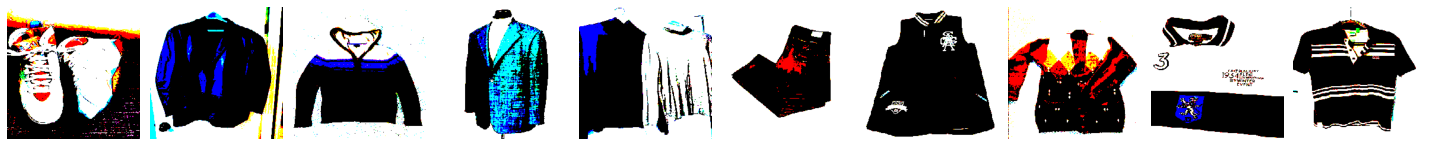

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [220]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(imgs)
print(labels)

In [223]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=14, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0         
_________________________________________________________________
dense (Dense)                (None, 14)                2809870   
Total params: 2,829,262
Trainable params: 2,829,262
Non-trainable params: 0
______________________________________________

In [226]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [227]:
model.fit(x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=10,
    verbose=2
)

Epoch 1/10


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node sequential/conv2d/Conv2D (defined at <ipython-input-227-c4ecaaffd38c>:6) ]] [Op:__inference_train_function_685]

Function call stack:
train_function


In [221]:
# data = np.array(data)
# labels = np.array(labels)

In [228]:
# X_train, X_test, ytrain, ytest = train_test_split(data, labels, test_size=0.2,
#                                                 random_state=42)

In [218]:
# datagen = ImageDataGenerator(rescale=1.0/255.0)

In [219]:
# train_iterator = datagen.flow(X_train, ytrain, batch_size=64)
# test_iterator = datagen.flow(X_test, ytest, batch_size=64)
# print('Batches train=%d, test=%d' % (len(train_iterator), len(test_iterator)))

In [220]:
# batchX, batchy = train_iterator.next()
# print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

In [ ]:
# datasets, info = tfds.load(name='horses_or_humans', with_info=True, as_supervised=True, split=['train', 'test'])

In [ ]:
# info

In [ ]:
# train, info_train = tfds.load(name='horses_or_humans', with_info=True, split='test')

# tfds.show_examples(info_train, train);

In [ ]:
# info_train

In [ ]:
# def scale(image,label):
#     image = tf.cast(image, tf.float32)
#     image /= 255.0
    
#     return tf.image.resize(image, [224,224], tf.one_hot(label, 2))

In [ ]:
# def get_dataset(batch_size=32):
#     train_dataset_scaled = datasets[0].map(scale).shuffle(1000).batch(batch_size)
#     test_dataset_scaled = datasets[1].map(scale).batch(batch_size)
#     return train_dataset_scaled, test_dataset_scaled

In [ ]:
# train_dataset_scaled = datasets[1].map(scale).shuffle(1000).batch(32)

In [222]:
# feature_extractor = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [223]:
# feature_extractor_layer = hub.KerasLayer(feature_extractor, input_shape=(224,224,3))

In [224]:
# feature_extractor_layer.trainable=False

In [225]:
# model = tf.keras.Sequential([
#     feature_extractor_layer,
#     tf.keras.layers.Dropout(0.3),
#     tf.keras.layers.Dense(14, activation='softmax')
# ])

# model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 14)                17934     
Total params: 2,275,918
Trainable params: 17,934
Non-trainable params: 2,257,984
_________________________________________________________________


In [226]:
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(),
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     metrics=['acc'])

In [229]:
# model.fit(x=X_train, y=ytrain, batch_size=10, epochs=5, shuffle=True, verbose=2)

Epoch 1/5


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node sequential/keras_layer/StatefulPartitionedCall/StatefulPartitionedCall/StatefulPartitionedCall/predict/MobilenetV2/Conv/Conv2D}}]] [Op:__inference_train_function_19072]

Function call stack:
train_function


In [195]:
train_path = 'imgs/train'
valid_path = 'imgs/valid'
test_path = 'imgs/test'

In [196]:
batch_size = 32

In [197]:
train_batches = ImageDataGenerator(rescale= 1. / 255, preprocessing_function=tf.keras.applications.resnet.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['boots', 'casualshirt', 'casualshoe', 'coat', 'dressshirt', 'dressshoe', 'jeans', 'pants', 'polos', 'shorts', 'sneakers', 'suits', 'sweaters', 'tshirts'], batch_size=batch_size)
valid_batches = ImageDataGenerator(rescale= 1. / 255, preprocessing_function=tf.keras.applications.resnet.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['boots', 'casualshirt', 'casualshoe', 'coat', 'dressshirt', 'dressshoe', 'jeans', 'pants', 'polos', 'shorts', 'sneakers', 'suits', 'sweaters', 'tshirts'], batch_size=batch_size)
test_batches = ImageDataGenerator(rescale= 1. / 255, preprocessing_function=tf.keras.applications.resnet.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['boots', 'casualshirt', 'casualshoe', 'coat', 'dressshirt', 'dressshoe', 'jeans', 'pants', 'polos', 'shorts', 'sneakers', 'suits', 'sweaters', 'tshirts'], batch_size=batch_size, shuffle=False)

Found 7000 images belonging to 14 classes.
Found 1400 images belonging to 14 classes.
Found 700 images belonging to 14 classes.


In [155]:
for i in train_batches:
    print(i)
    break

(array([[[[-4.68196236e-02,  1.96945116e-01, -1.59529418e-01],
         [-7.03490376e-02,  1.73415706e-01, -1.83058828e-01],
         [-7.03490376e-02,  1.73415706e-01, -1.83058828e-01],
         ...,
         [-5.85843287e-02,  2.08709821e-01, -1.83058828e-01],
         [-5.85843287e-02,  2.08709821e-01, -1.83058828e-01],
         [-6.64274693e-02,  2.12631389e-01, -1.83058828e-01]],

        [[-8.21137428e-02,  1.53807849e-01, -1.47764713e-01],
         [-5.46627603e-02,  1.81258842e-01, -1.20313734e-01],
         [-5.46627603e-02,  1.81258842e-01, -1.20313734e-01],
         ...,
         [-9.78000164e-02,  1.73415706e-01, -1.55607849e-01],
         [-9.78000164e-02,  1.73415706e-01, -1.55607849e-01],
         [-8.21137428e-02,  1.93023548e-01, -1.43843144e-01]],

        [[-6.64274693e-02,  1.73415706e-01, -1.04627460e-01],
         [-7.42706060e-02,  1.65572569e-01, -1.12470597e-01],
         [-7.42706060e-02,  1.65572569e-01, -1.12470597e-01],
         ...,
         [-9.38784480e-

In [158]:
len(train_batches.filenames)

7000

In [198]:
img_width, img_height = 224, 224

#top_model_weights_path = 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
# train_data_dir = "./imgs/fashion_data/Footwear/Men/Images/"

train_data_dir = test_path

nb_train_samples = 700
epochs = 1
# batch_size = 1

def extract_features():
    Itemcodes = []
    
#     model = applications.ResNet50(include_top=False, weights='imagenet')
    model = applications.ResNet50(include_top=False, weights='imagenet')

    seq_model = keras.Sequential([model,keras.layers.GlobalAveragePooling2D()])

#     generator = datagen.flow_from_directory(
#         train_data_dir,
#         target_size=(img_width, img_height),
#         batch_size=batch_size,
#         class_mode=None,
#         shuffle=False)
    generator = test_batches
    for i in generator.filenames:
        Itemcodes.append(i[(i.find("/")+1):i.find(".")])
    extracted_features = seq_model.predict(generator, steps=(700//32), verbose=1)
#     extracted_features = extracted_features.reshape((-1, 100352))
    
    np.save(open('./imgs/Men1_ResNet_features.npy', 'wb'), extracted_features)
    np.save(open('./imgs/Men1_ResNet_feature_product_ids.npy', 'wb'), np.array(Itemcodes))
    
    return extracted_features
    
a = datetime.now()
x = extract_features()
print("Time taken in feature extraction", datetime.now()-a)

21/21 [==============================] - 2s 98ms/step
Time taken in feature extraction 0:00:06.349559


boots1012


In [178]:
# model = applications.ResNet50(include_top=False, weights='imagenet')

# seq_model = keras.Sequential([model,keras.layers.GlobalAveragePooling2D()])

# seq_model.summary()

# x = seq_model.predict(train_batches, steps=(7000//32)+1, verbose=1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, None, None, 2048)  23587712  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
_________________________________________________________________
219/219 [==============================] - 23s 106ms/step


In [199]:
x.shape

(672, 2048)

In [200]:
extracted_features = np.load('./imgs/Men1_ResNet_features.npy')
Productids = np.load('./imgs/Men1_ResNet_feature_product_ids.npy')

# men = pd.read_csv('./footwear_men.csv')
df_Productids = list(mens['ProductId'])
Productids = list(Productids)

In [201]:
type(extracted_features),extracted_features.shape

(numpy.ndarray, (672, 2048))

In [202]:
type(Productids), len(Productids)

(list, 700)

In [214]:
Productids[400:500]

['10373',
 '10493',
 '12052',
 '12366',
 '12873',
 '12970',
 '13538',
 '13673',
 '14021',
 '14633',
 '14788',
 '14804',
 '14952',
 '15248',
 '15305',
 '17354',
 '18033',
 '18954',
 '19084',
 '19952',
 '20425',
 '20512',
 '21288',
 '21296',
 '21380',
 '21674',
 '22678',
 '23317',
 '24124',
 '25245',
 '2592',
 '2734',
 '27783',
 '27912',
 '2805',
 '28392',
 '29285',
 '29586',
 '29813',
 '30188',
 '30206',
 '3095',
 '31014',
 '31122',
 '34066',
 '365',
 '6176',
 '6802',
 '8075',
 '8198',
 '10687',
 '1136',
 '11558',
 '11838',
 '11872',
 '12762',
 '12809',
 '12870',
 '13271',
 '13975',
 '15050',
 '15282',
 '15762',
 '16077',
 '16080',
 '17083',
 '17675',
 '18124',
 '184',
 '18911',
 '18944',
 '19276',
 '21',
 '2113',
 '2123',
 '22173',
 '22197',
 '22384',
 '22620',
 '22943',
 '23340',
 '23766',
 '23841',
 '24253',
 '24447',
 '2469',
 '25300',
 '2585',
 '26552',
 '26734',
 '2896',
 '3065',
 '3212',
 '3829',
 '6098',
 '6344',
 '6387',
 '6786',
 '6896',
 '8553']

==================== input product image ====================


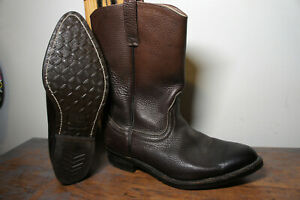

Product Title:  MINT Vintage BROWNING 11.5 Leather Slip On Pecos Style Vtg Hunting Boots Pull On

 ==================== Recommended products ====================


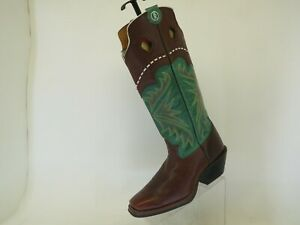

Product Title:  Tony Lama Green Brown Leather Buckaroo Tall Cowboy Western Boots Men Size 9.5 D
Euclidean Distance from input image: 0.0


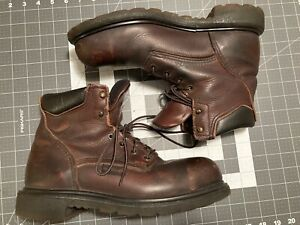

Product Title:  Red Wing Shoes Supersole 2.0 Safety Toe Workboots Mens 9.5 D Style 2406
Euclidean Distance from input image: 1.8359811


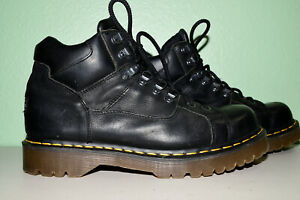

Product Title:  Dr Martens DM 8699 Bex Sole Boots Black Men US 13
Euclidean Distance from input image: 1.8359811


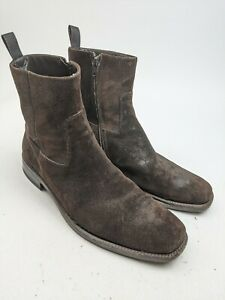

Product Title:  To Boot New York Brown Suede Side Zip Ankle Boots Sz 9.5 
Euclidean Distance from input image: 1.9011238


In [223]:
def get_similar_products_cnn(product_id, num_results):
    doc_id = Productids.index(product_id)
    pairwise_dist = pairwise_distances(extracted_features, extracted_features[doc_id].reshape(1,-1))
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]
    print("="*20, "input product image", "="*20)
    ip_row = mens[['image_link','title']].loc[mens['ProductId']==int(Productids[indices[0]])]
    #print(ip_row.head())
    for indx, row in ip_row.iterrows():
        display(Image(url=row['image_link'], width = 224, height = 224,embed=True))
        print('Product Title: ', row['title'])
    print("\n","="*20, "Recommended products", "="*20)
    for i in range(1,len(indices)):
        rows = mens[['image_link','title']].loc[mens['ProductId']==int(Productids[indices[i]])]
        for indx, row in rows.iterrows():
            display(Image(url=row['image_link'], width = 224, height = 224,embed=True))
            print('Product Title: ', row['title'])
            print('Euclidean Distance from input image:', pdists[i])

get_similar_products_cnn('11838', 5)

In [220]:
def get_similar_products_cnn(category, product_id, num_results):
    doc_id = Productids.index(product_id)
    pairwise_dist = pairwise_distances(extracted_features, extracted_features[doc_id].reshape(1,-1))
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]
    print("="*20, "input product image", "="*20)
    ip_row = mens[['image_link','title']].loc[mens['ProductId']==int(Productids[indices[0]])]
    #print(ip_row.head())
    for indx, row in ip_row.iterrows():
        display(Image(url=row['image_link'], width = 224, height = 224,embed=True))
        print('Product Title: ', row['title'])
    print("\n","="*20, "Recommended products", "="*20)
    for i in range(1,len(indices)):
        rows = mens[['image_link','title']].loc[mens['ProductId']==int(Productids[indices[i]])]
        for indx, row in rows.iterrows():
            display(Image(url=row['image_link'], width = 224, height = 224,embed=True))
            print('Product Title: ', row['title'])
            print('Euclidean Distance from input image:', pdists[i])

get_similar_products_cnn('11838', 5)

NameError: name 'indices' is not defined

In [226]:
Productids.index('21')

472